In [307]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pyvoro as voro

# Voronoi-Laguerre diagrams

In [308]:
#set seeds for random number generators
np.random.seed(0)

#generate random particle seeds and radii
seeds = np.random.random([30,2])*10
radii = np.random.random([len(seeds)])+0.1

vor = voro.compute_2d_voronoi(
  seeds,
  [[0,10], [0,10]], # limits
  2.0, # block size
)

vor_weighted = voro.compute_2d_voronoi(
  seeds,
  [[0,10], [0,10]], # limits
  2.0, # block size
  radii=radii,
)

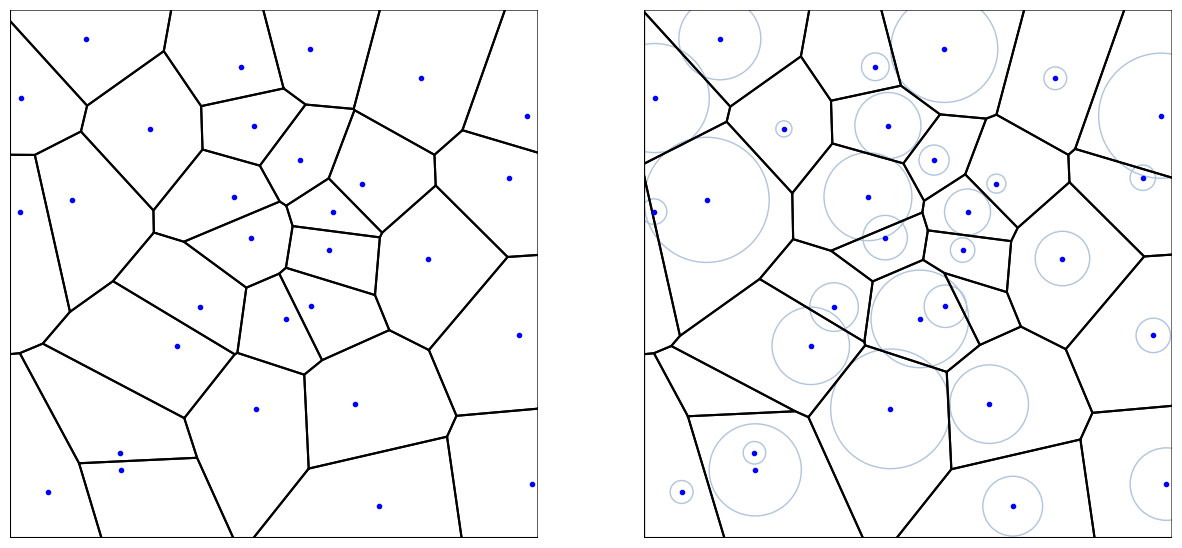

In [309]:
#Show diagrams
fig, axs = plt.subplots(1,2, figsize=(15, 15))

for i in vor:
    poly = Polygon(i['vertices'])
    x,y = poly.exterior.xy
    axs[0].plot(x,y,'black')

for i in vor_weighted:
    poly = Polygon(i['vertices'])
    x,y = poly.exterior.xy
    axs[1].plot(x,y,'black')

for i in zip(seeds,radii):
    seed = i[0]
    for ax in axs: ax.plot(seed[0],seed[1],'b.')
    particle = plt.Circle((seed[0],seed[1]), i[1]*1.1, fill=False, color='lightsteelblue')
    axs[1].add_patch(particle)

for ax in axs: 
    ax.set_xlim([0,10])
    ax.set_ylim([0,10])
    ax.axis('off')
    ax.set_aspect('equal')
plt.show()

# Voronoi relaxation

In [310]:
#Conventional Lloyds algorythm
seeds_cent = np.copy(seeds)
energy_func = []
energy = 1000

while energy > 0.01:
    energy = 0
    vor_cent = voro.compute_2d_voronoi(
        seeds_cent,
        [[0,10], [0,10]],
        2.0,
        # radii=radii,          #uncomment to perform weighted relaxation
        # periodic = [True]*2   #uncomment for periodic boundary conditions
    )
    for j,cell in enumerate(vor_cent):
        energy += ((seeds_cent[j][0] - Polygon(cell['vertices']).centroid.x)**2+(seeds_cent[j][1] - Polygon(cell['vertices']).centroid.y)**2)**0.5
        seeds_cent[j][0] = Polygon(cell['vertices']).centroid.x
        seeds_cent[j][1] = Polygon(cell['vertices']).centroid.y
    energy_func.append(energy/len(seeds_cent))

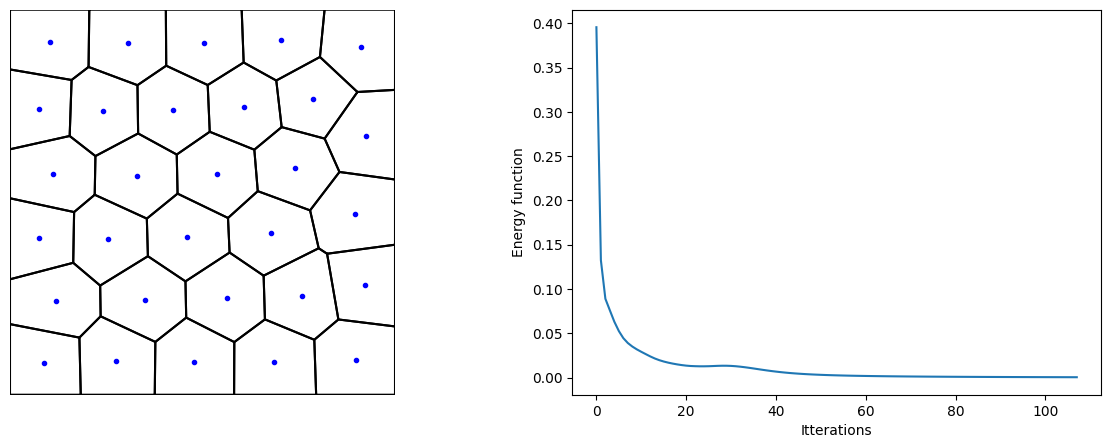

In [311]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

for i in vor_cent:
    poly = Polygon(i['vertices'])
    x,y = poly.exterior.xy
    axs[0].plot(x,y,'black')

for i in zip(seeds_cent,radii):
    seed = i[0]
    axs[0].plot(seed[0],seed[1],'b.')
    # particle = plt.Circle((seed[0],seed[1]), i[1], fill=False, color='lightsteelblue')
    # axs[0].add_patch(particle)  #uncomment to show radii

axs[0].set_xlim([0,10])
axs[0].set_ylim([0,10])
axs[0].axis('off')
axs[0].set_aspect('equal')

axs[1].set_xlabel('Itterations')
axs[1].set_ylabel('Energy function')
axs[1].plot(np.arange(0,len(energy_func),1),energy_func)
plt.show()

# Voro_pack

In [325]:
#Define a polygon as a numpy array of points
polygon = np.array([[1, 3],
       [5, 5],
       [8, 2],
       [5, 1],
       [4, 2],
       [5, 3],
       [1, 3]])

#Compute bounding box
xmin,ymin = min(polygon[:,0]),min(polygon[:,1])
xmax,ymax = max(polygon[:,0]),max(polygon[:,1])
width,height = xmax-xmin,ymax-ymin

#TODO: Allow user defined polygons

In [326]:
#Read and format PSD data
size_dist = pd.read_csv('./PSD/PSD.csv',delimiter='\s+',names=['diam','vol'])
size_dist['diam'] = size_dist['diam']/1000 #convert from μm to m
size_dist['rad'] = size_dist['diam']/2
size_dist['freq'] = size_dist['vol']/(size_dist['vol'] * (size_dist['rad'])**3)
size_dist['freq'] = size_dist['freq']/(size_dist['freq'].sum())
size_dist['freq'] = size_dist['freq'].fillna(0.)
cfd = [0]
for i,v in enumerate(size_dist['freq'][:-1]):
    cfd.append(v+cfd[i])
size_dist['cfd'] = cfd
dmin = size_dist['diam'].min()
dmax = size_dist['diam'].max()
#Check PSD
print('User defined PSD\n')
print(size_dist)

#Function for generating radii from PSD
def generate_radius() -> float:
    '''Generates a new particle radius sampled from the user defined PSD using a linear interpolation between sive sizes'''
    rnd =  np.random.random()
    i = 0
    while rnd > size_dist['cfd'][i] and i<len(size_dist['cfd']): i+=1
    return (size_dist['rad'][i-1] + ((rnd - size_dist['cfd'][i-1])*(size_dist['rad'][i]-size_dist['rad'][i-1]))/(size_dist['cfd'][i]-size_dist['cfd'][i-1]))

User defined PSD

   diam   vol   rad      freq       cfd
0   0.1  0.00  0.05  0.000000  0.000000
1   0.2  0.05  0.10  0.646974  0.000000
2   0.3  0.15  0.15  0.191696  0.646974
3   0.4  0.30  0.20  0.080872  0.838670
4   0.5  0.30  0.25  0.041406  0.919542
5   0.6  0.15  0.30  0.023962  0.960948
6   0.7  0.05  0.35  0.015090  0.984910
7   0.8  0.00  0.40  0.000000  1.000000


In [327]:
#Generate inital positions for voronoi seeds
area  = width*height
TARGET_DENSITY = 0.8 #max density for 2D close packing
den = 0
radii = []
while(den < TARGET_DENSITY):
    radius = generate_radius()
    den += (np.pi * radius**2)/area
    radii.append(radius)

pos = []
for i in range(len(radii)):
    pos.append(np.random.random(2)*[width,height]+[xmin,ymin])
pos = np.array(pos)

positions_inital = np.array((pos[:,0],pos[:,1],radii)).T


In [328]:
#Lloyds algorythm with particle growth
positions_centroidal = np.copy(positions_inital)
energy_func = []
energy = 1000
scale = 0

while scale < 1 or energy > 0.1:
    energy = 0
    #commpute voronoi diagram
    vor_cent = voro.compute_2d_voronoi(
        positions_centroidal[:,:2],
        [[xmin,xmax], [ymin,ymax]],
        2.0,
        radii=positions_centroidal[:,2]*scale, # particle radii modified by scale factor
        periodic = [True]*2 #periodic boundry conditions
    )
    for j,cell in enumerate(vor_cent):
        #commpute energy function
        energy += ((positions_centroidal[j][0] - Polygon(cell['vertices']).centroid.x)**2\
        +(positions_centroidal[j][1] - Polygon(cell['vertices']).centroid.y)**2)**0.5
        #move positions to cell centroid
        positions_centroidal[j][0] = Polygon(cell['vertices']).centroid.x
        positions_centroidal[j][1] = Polygon(cell['vertices']).centroid.y
    energy_func.append(energy/len(positions_centroidal))
    if scale < 1:
        scale += 0.1
    else: scale = 1

In [329]:
#Find maximum bounding circle in each cell
particles = []

for i in vor_cent:
    verts = i['vertices']
    verts = [j.tolist() for j in verts]
    verts = np.array(verts+[verts[0]])
    centroid = np.array([verts[:-1,0].sum(),verts[:-1,1].sum()])/(len(verts)-1)
    b = np.ones(len(verts)-1)
    a = []
    count = 0
    #find constraint equations describing cell faces
    for p1,p2 in zip(verts,verts[1:]):
        m = (p1[1]-p2[1])/(p1[0]-p2[0])
        c = p1[1]-m*p1[0]
        a2 = 1/c
        a1 = a2*-m
        #flip plane if contains centroid
        if(a1*centroid[0] +a2*centroid[1] > 1):
            a1,a2 = -a1,-a2
            b[count] = - b[count]
        count += 1
        a.append([a1,a2])
    a = np.array(a)
    #find max radius and Chebeshev center
    radius = cp.Variable(1)
    center = cp.Variable(2)
    constraints = [a[i].T@center + np.linalg.norm(a[i], 2)*radius <= b[i] for i in range(len(a))]
    objective = cp.Maximize(radius)
    p = cp.Problem(objective, constraints)
    # The optimal objective is returned by p.solve()
    result = p.solve()
    particles.append([center.value[0],center.value[1],radius.value[0]])

In [330]:
#Trim particles outside polygon
shell = Polygon(polygon)
particles_trimed = np.array([i for i in particles if shell.contains(Point(i[:2]))])

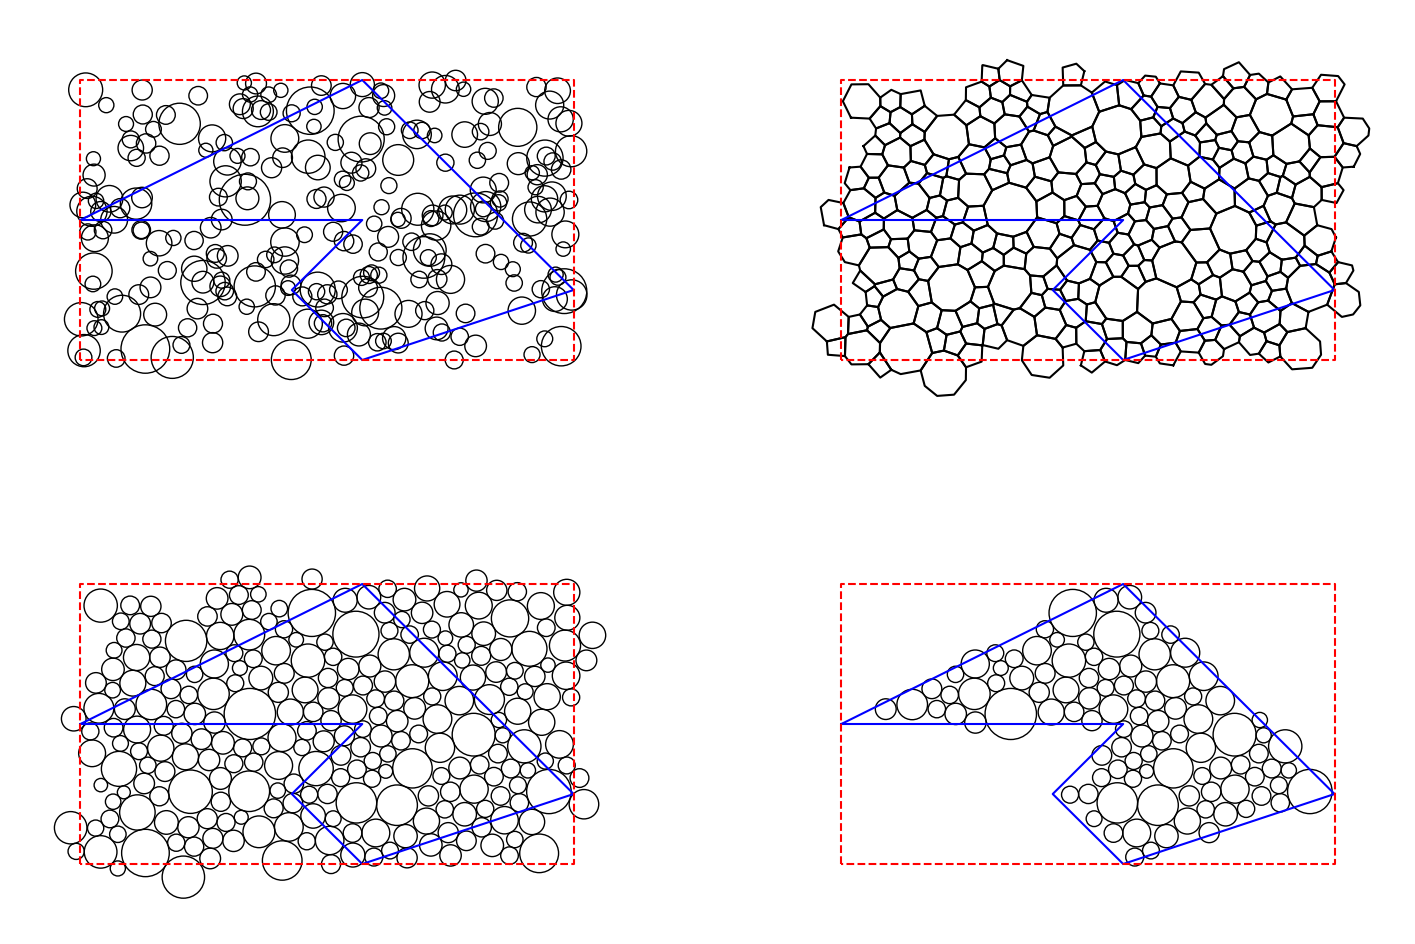

In [333]:
#Display results from each step
fig, axs = plt.subplots(2,2, figsize=(18, 12))

for position in positions_inital:
    axs[0,0].add_patch(plt.Circle((position[0],position[1]),position[2], fill=False, color = 'black'))

for i in vor_cent:
    poly = Polygon(i['vertices'])
    x,y = poly.exterior.xy
    axs[0,1].plot(x,y,'black')

for particle in particles:
    axs[1,0].add_patch(plt.Circle((particle[0],particle[1]),particle[2], fill=False, color = 'black'))

for particle in particles_trimed:
    axs[1,1].add_patch(plt.Circle((particle[0],particle[1]),particle[2], fill=False, color = 'black'))


for row in axs:
    for ax in row:
        ax.plot(polygon[:,0],polygon[:,1],color = 'blue')
        ax.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
        ax.set_xlim([xmin-1,xmax+1])
        ax.set_ylim([ymin-1,ymax+1])
        ax.axis('off')
plt.show()